In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
device

'cuda'

In [2]:
# import requests
# from pathlib import Path 

# # Download helper functions from Learn PyTorch repo (if not already downloaded)
# if Path("helper_functions.py").is_file():
#   print("helper_functions.py already exists, skipping download")
# else:
#   print("Downloading helper_functions.py")
#   # Note: you need the "raw" GitHub URL for this to work
#   request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
#   with open("helper_functions.py", "wb") as f:
#     f.write(request.content)

In [3]:
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [4]:
df = pd.read_csv('baseline_data.csv')

/tmp/ipykernel_15873/2305619842.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('baseline_data.csv')


In [5]:
df.head()

,mrd_type,original_list_price,list_price,close_price,association_fee,tax_annual_amount,days_on_market,postal_code,rooms_total,bedrooms_total,...,garage_spaces,lot_size_acres,living_area,year_built,public_remarks,elementary_school_district,middle_or_junior_school_district,high_school_district,waterfront_yn,street_dir_prefix
0,Detached Single,189900.0,189900.0,190000.0,0.0,1102.0,3,46366,9,3,...,2.0,0.0,1886,1875,"Perfectly situated on 10 acres of land, this 3...",NaN,NaN,NaN,False,W
1,Attached Single,2992002.0,2992002.0,2749916.0,1619.0,0.0,26,60601,7,3,...,1.0,0.0,2586,0,Introducing Vista Residences Chicago's New Lux...,299,299,299,True,E
2,Attached Single,1969100.0,1969100.0,1670267.0,1064.0,0.0,2,60601,6,3,...,1.0,0.0,2804,0,Introducing Vista Residences Chicago's New Lux...,299,299,299,True,E
3,Attached Single,1164240.0,1164240.0,1085145.0,633.0,0.0,2,60601,4,1,...,1.0,0.0,1176,0,Introducing Vista Residences Chicago's New Lux...,299,299,299,True,E
4,Attached Single,1380000.0,1470670.0,1306059.0,750.0,0.0,5,60601,7,2,...,1.0,0.0,2000,0,Introducing Vista Residences Chicago's New Lux...,299,299,299,True,E


In [6]:
df.info()
df = df.drop(['street_dir_prefix'],axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400918 entries, 0 to 400917
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   mrd_type                          400918 non-null  object 
 1   original_list_price               400918 non-null  float64
 2   list_price                        400918 non-null  float64
 3   close_price                       400918 non-null  float64
 4   association_fee                   400918 non-null  float64
 5   tax_annual_amount                 400918 non-null  float64
 6   days_on_market                    400918 non-null  int64  
 7   postal_code                       400918 non-null  object 
 8   rooms_total                       400918 non-null  int64  
 9   bedrooms_total                    400918 non-null  int64  
 10  bathrooms_full                    400918 non-null  int64  
 11  bathrooms_half                    400918 non-null  i

In [7]:
df.columns

Index(['mrd_type', 'original_list_price', 'list_price', 'close_price',
       'association_fee', 'tax_annual_amount', 'days_on_market', 'postal_code',
       'rooms_total', 'bedrooms_total', 'bathrooms_full', 'bathrooms_half',
       'garage_spaces', 'lot_size_acres', 'living_area', 'year_built',
       'public_remarks', 'elementary_school_district',
       'middle_or_junior_school_district', 'high_school_district',
       'waterfront_yn'],
      dtype='object')

In [8]:
unique_elementary = df[["postal_code","elementary_school_district"]].groupby(["postal_code","elementary_school_district"]).size().reset_index().rename(columns={0:'count'})
unique_middle = df[["postal_code","middle_or_junior_school_district"]].groupby(["postal_code","middle_or_junior_school_district"]).size().reset_index().rename(columns={0:'count'})
unique_high = df[["postal_code","high_school_district"]].groupby(["postal_code","high_school_district"]).size().reset_index().rename(columns={0:'count'})

In [9]:
el_dict = dict(zip(unique_elementary.postal_code, unique_elementary.elementary_school_district))
md_dict = dict(zip(unique_middle.postal_code, unique_middle.middle_or_junior_school_district))
hs_dict = dict(zip(unique_high.postal_code, unique_high.high_school_district))

In [10]:
df.public_remarks = df.public_remarks.fillna('')
df.elementary_school_district = df.elementary_school_district.fillna(df.postal_code.map(el_dict))
df.middle_or_junior_school_district = df.middle_or_junior_school_district.fillna(df.postal_code.map(md_dict))
df.high_school_district = df.high_school_district.fillna(df.postal_code.map(hs_dict))

In [11]:
df = df.dropna(axis=0)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400040 entries, 1 to 400917
Data columns (total 21 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   mrd_type                          400040 non-null  object 
 1   original_list_price               400040 non-null  float64
 2   list_price                        400040 non-null  float64
 3   close_price                       400040 non-null  float64
 4   association_fee                   400040 non-null  float64
 5   tax_annual_amount                 400040 non-null  float64
 6   days_on_market                    400040 non-null  int64  
 7   postal_code                       400040 non-null  object 
 8   rooms_total                       400040 non-null  int64  
 9   bedrooms_total                    400040 non-null  int64  
 10  bathrooms_full                    400040 non-null  int64  
 11  bathrooms_half                    400040 non-null  int64 

In [13]:
cat_cols = list(df.select_dtypes(include=['object','bool']).columns)
num_cols = list(df.select_dtypes(include=['float64','int64']).columns)

cat_cols.remove('public_remarks',)
num_cols.remove('close_price')

df_text = df[['public_remarks']].reset_index(drop='True').astype('string')
df_target = df[['close_price']].reset_index(drop='True')

df_cat = df[cat_cols].reset_index(drop='True').astype('string')

df_num = df[num_cols].reset_index(drop='True')

In [14]:
df_cat.columns

Index(['mrd_type', 'postal_code', 'elementary_school_district',
       'middle_or_junior_school_district', 'high_school_district',
       'waterfront_yn'],
      dtype='object')

In [15]:
df_num.columns

Index(['original_list_price', 'list_price', 'association_fee',
       'tax_annual_amount', 'days_on_market', 'rooms_total', 'bedrooms_total',
       'bathrooms_full', 'bathrooms_half', 'garage_spaces', 'lot_size_acres',
       'living_area', 'year_built'],
      dtype='object')

In [16]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400040 entries, 0 to 400039
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   original_list_price  400040 non-null  float64
 1   list_price           400040 non-null  float64
 2   association_fee      400040 non-null  float64
 3   tax_annual_amount    400040 non-null  float64
 4   days_on_market       400040 non-null  int64  
 5   rooms_total          400040 non-null  int64  
 6   bedrooms_total       400040 non-null  int64  
 7   bathrooms_full       400040 non-null  int64  
 8   bathrooms_half       400040 non-null  int64  
 9   garage_spaces        400040 non-null  float64
 10  lot_size_acres       400040 non-null  float64
 11  living_area          400040 non-null  int64  
 12  year_built           400040 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 39.7 MB


In [17]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400040 entries, 0 to 400039
Data columns (total 6 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   mrd_type                          400040 non-null  string
 1   postal_code                       400040 non-null  string
 2   elementary_school_district        400040 non-null  string
 3   middle_or_junior_school_district  400040 non-null  string
 4   high_school_district              400040 non-null  string
 5   waterfront_yn                     400040 non-null  string
dtypes: string(6)
memory usage: 18.3 MB


In [18]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400040 entries, 0 to 400039
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   close_price  400040 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB


In [19]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(df_cat).toarray()
feature_labels = ohe.get_feature_names_out()
df_cat_encoded = pd.DataFrame(feature_arr, columns=feature_labels)
df_cat_encoded.head()

,mrd_type_Attached Single,mrd_type_Detached Single,postal_code_46075,postal_code_46168,postal_code_46324,postal_code_46360,postal_code_46373,postal_code_47804,postal_code_47847,postal_code_47862,...,high_school_district_VALM,high_school_district_WAS3,high_school_district_WATE,high_school_district_WEBS,high_school_district_WENT,high_school_district_keno,high_school_district_kenos,high_school_district_salem,waterfront_yn_False,waterfront_yn_True
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
df_features = pd.concat([df_num,df_cat_encoded], axis = 1)

In [21]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400040 entries, 0 to 400039
Columns: 2350 entries, original_list_price to waterfront_yn_True
dtypes: float64(2343), int64(7)
memory usage: 7.0 GB


In [22]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400040 entries, 0 to 400039
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   public_remarks  400040 non-null  string
dtypes: string(1)
memory usage: 3.1 MB


In [23]:
df_features.isnull().values.any()

False

In [24]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

BATCH_SIZE = 64

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.33)

min_max_scale = MinMaxScaler()
X_train[num_cols] = min_max_scale.fit_transform(X_train[num_cols])
X_test[num_cols] = min_max_scale.transform(X_test[num_cols])

print(X_train.isnull().values.any(),X_test.isnull().values.any())

X_train = torch.from_numpy(X_train.values).type(torch.float).to(device)
X_test = torch.from_numpy(X_test.values).type(torch.float).to(device)
y_train = torch.from_numpy(y_train.values).type(torch.float).to(device)
y_test = torch.from_numpy(y_test.values).type(torch.float).to(device)

False False


In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([268026, 2350]),
 torch.Size([132014, 2350]),
 torch.Size([268026, 1]),
 torch.Size([132014, 1]))

In [26]:
train_data = list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

In [27]:
train_dataloader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

In [28]:
tmp_x, tmp_y, = next(iter(train_dataloader))
tmp_x.shape,tmp_y.shape, tmp_x.device, tmp_y.device

(torch.Size([64, 2350]),
 torch.Size([64, 1]),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [29]:
device

'cuda'

In [30]:
input_shape = tmp_x.shape[-1]
output_shape = 1

In [51]:
class RealEstatePredictor(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, output_shape: int, p: float):
        super().__init__()
        self.linear1 = nn.Linear(in_features=input_shape, out_features=hidden_units_1)
        self.hidden_act1 = nn.ReLU()
        self.dropout_layer1 = nn.Dropout(p=p)
        self.linear2 = nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2)
        self.hidden_act2 = nn.ReLU()
        self.dropout_layer2 = nn.Dropout(p=p)
        self.linear3 = nn.Linear(in_features=hidden_units_2, out_features=output_shape)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.hidden_act1(x)
        x = self.dropout_layer1(x)
        x = self.linear2(x)
        x = self.hidden_act2(x)
        x = self.dropout_layer2(x)
        x = self.linear3(x)
        return x

In [52]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [53]:
model_0 = RealEstatePredictor(input_shape=input_shape,
    hidden_units_1=100, # how many units in the hiden layer
    hidden_units_2=100, # how many units in the hiden layer
    output_shape=output_shape, # one for every class
    p = .2
)
model_0.apply(weights_init_uniform_rule)
model_0.to(device)

RealEstatePredictor(
  (linear1): Linear(in_features=2350, out_features=100, bias=True)
  (hidden_act1): ReLU()
  (dropout_layer1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (hidden_act2): ReLU()
  (dropout_layer2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)

In [54]:
model_0.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0020,  0.0074, -0.0044,  ..., -0.0202, -0.0136,  0.0175],
                      [ 0.0066,  0.0105, -0.0150,  ..., -0.0015,  0.0151,  0.0200],
                      [-0.0022,  0.0138,  0.0082,  ...,  0.0024,  0.0189,  0.0074],
                      ...,
                      [ 0.0146, -0.0158, -0.0171,  ...,  0.0018,  0.0137, -0.0173],
                      [-0.0075, -0.0024,  0.0128,  ..., -0.0049, -0.0111,  0.0030],
                      [ 0.0002, -0.0083,  0.0072,  ..., -0.0135,  0.0195, -0.0066]],
                     device='cuda:0')),
             ('linear1.bias',
              tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            

In [55]:
loss_fn = nn.MSELoss()
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

In [56]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [57]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
# Set the seed and start the timer
train_time_start_on_cpu = timer()

epochs = 125

train_loss_list = []
test_loss_list = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), 5)
        
        # 5. Optimizer step
        optimizer.step()
        
        if batch % 2000 == 0:
            # print(train_loss, loss)
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    
    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)
    test_loss = 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        test_loss_list.append(test_loss)

        # Divide total accuracy by length of test dataloader (per batch)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/268026 samples
Looked at 128000/268026 samples
Looked at 256000/268026 samples

Train loss: 48752566272.00000 | Test loss: 15855105024.00000
Epoch: 1
-------
Looked at 0/268026 samples
Looked at 128000/268026 samples
Looked at 256000/268026 samples

Train loss: 12018121728.00000 | Test loss: 6196777472.00000
Epoch: 2
-------
Looked at 0/268026 samples
Looked at 128000/268026 samples
Looked at 256000/268026 samples

Train loss: 6516444160.00000 | Test loss: 4320909312.00000
Epoch: 3
-------
Looked at 0/268026 samples
Looked at 128000/268026 samples
Looked at 256000/268026 samples

Train loss: 5179950080.00000 | Test loss: 3689318400.00000
Epoch: 4
-------
Looked at 0/268026 samples
Looked at 128000/268026 samples
Looked at 256000/268026 samples

Train loss: 4684831744.00000 | Test loss: 3237732352.00000
Epoch: 5
-------
Looked at 0/268026 samples
Looked at 128000/268026 samples
Looked at 256000/268026 samples

Train loss: 4097004544.00000 | Test loss: 308091

<function matplotlib.pyplot.show(close=None, block=None)>

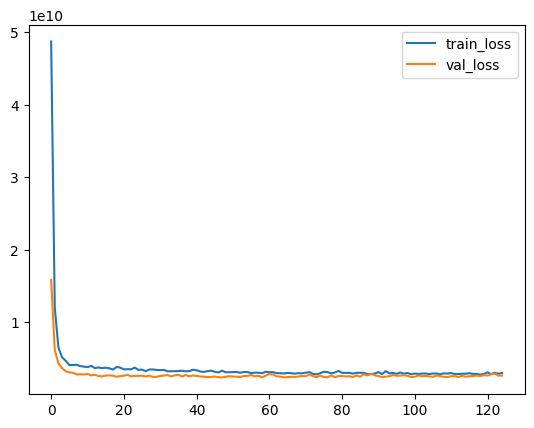

In [58]:
for i, n in enumerate(train_loss_list):
    train_loss_list[i] = n.detach().cpu().numpy()

for i, n in enumerate(test_loss_list):
    test_loss_list[i] = n.detach().cpu().numpy()
    
from matplotlib import pyplot as plt
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list,label='val_loss')
plt.legend()
plt.show


In [59]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    predictions = []
    actual = []
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            predictions.append(y_pred)
            actual.append(y)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()}, predictions, actual

# Calculate model 0 results on test dataset
model_0_results, predictions, actual = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn
)
model_0_results

{'model_name': 'RealEstatePredictor', 'model_loss': 2642085632.0}

In [60]:
len(predictions)

2063

In [61]:
len(actual)

2063

In [62]:
len(X_test)

132014

In [63]:
actual_output = []
for raw in actual:
    actual_output.extend(raw.flatten().tolist())
predictions_output = [] 
for raw in predictions:
    predictions_output.extend(raw.flatten().tolist())

In [64]:
df_actual = pd.DataFrame(actual_output,columns=['actual'])
df_predictions = pd.DataFrame(predictions_output,columns=['predictions'])

df_out = pd.concat([df_actual,df_predictions],axis=1)

In [65]:
df_out

,actual,predictions
0,375000.0,368382.53125
1,355000.0,332846.78125
2,165500.0,171205.53125
3,294500.0,294087.59375
4,141500.0,146928.62500
...,...,...
132009,625000.0,623819.62500
132010,555000.0,539177.56250
132011,358000.0,361122.81250
132012,322500.0,331652.84375


In [66]:
df_out['diff'] = df_out.actual-df_out.predictions

In [67]:
df_out

,actual,predictions,diff
0,375000.0,368382.53125,6617.46875
1,355000.0,332846.78125,22153.21875
2,165500.0,171205.53125,-5705.53125
3,294500.0,294087.59375,412.40625
4,141500.0,146928.62500,-5428.62500
...,...,...,...
132009,625000.0,623819.62500,1180.37500
132010,555000.0,539177.56250,15822.43750
132011,358000.0,361122.81250,-3122.81250
132012,322500.0,331652.84375,-9152.84375


In [68]:
abs(df_out['diff']).mean()

18096.410903618354

In [69]:
df_out.to_csv('price_prediction.csv')